In [1]:
# "Supervised Learning for Earthquake Magnitude Classification using Neural Networks"
# Hancy Campos | Ruben John Madeja
# CPE215 Neural Networks

In [2]:
# This cell imports necessary specifications and collects the data.

import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf

with zipfile.ZipFile('earthquake-database.zip', 'r') as zip_ref:
    zip_ref.extractall('earthquake_dataset1')

with zipfile.ZipFile('earthquakes-2000-2023.zip', 'r') as zip_ref:
    zip_ref.extractall('earthquake_dataset2')

In [3]:
# This cell preprocesses the 1st dataset of earthquake data from the US National Earthquake Information Center (NEIC), covering 1965 to 2016.

file_path = 'earthquake_dataset1/database.csv'
data = pd.read_csv(file_path)

columns_to_keep = ['Date', 'Time', 'Latitude', 'Longitude', 'Depth', 'Magnitude', 'Magnitude Type', 'Root Mean Square']
data = data[columns_to_keep]

data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data = data.dropna(subset=['Date'])
data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')

preprocessed_file_path = 'preprocessed_1965-2016_earthquake.csv'
data.to_csv(preprocessed_file_path, index=False)

print("Preprocessed data saved to:", preprocessed_file_path)

data = pd.read_csv(preprocessed_file_path)

num_columns = data.shape[1]
num_rows = data.shape[0]
dataset_size = data.memory_usage().sum() / (1024 * 1024)  # in MB

print("Number of columns:", num_columns)
print("Number of rows:", num_rows)
print("Dataset size:", round(dataset_size, 2), "MB")

Preprocessed data saved to: preprocessed_1965-2016_earthquake.csv
Number of columns: 8
Number of rows: 23409
Dataset size: 1.43 MB


In [4]:
# This cell preprocesses the 2nd dataset of earthquake data from the US Geological Survey-Earthquake Hazards Program (USGS-EHP), covering 2000 to 2023.

csv_file_path = 'earthquake_dataset2/earthquakes-2000-01-01-2023-02-12.csv'
data = pd.read_csv(csv_file_path)

data['time'] = pd.to_datetime(data['time'])
data['Date'] = data['time'].dt.strftime('%Y-%m-%d')
data['Time'] = data['time'].dt.strftime('%H:%M:%S')

columns_to_keep = ['Date', 'Time', 'latitude', 'longitude', 'depth', 'mag', 'magType', 'rms']
data = data[columns_to_keep]

data = data.rename(columns={'latitude': 'Latitude', 'longitude': 'Longitude', 
                            'depth': 'Depth', 'mag': 'Magnitude', 
                            'magType': 'Magnitude Type', 'rms': 'Root Mean Square'})

data['Magnitude Type'] = data['Magnitude Type'].str.upper()

preprocessed_file_path = 'preprocessed_2000-2023_earthquake.csv'
data.to_csv(preprocessed_file_path, index=False)

print("Preprocessed data saved to:", preprocessed_file_path)

data = pd.read_csv(preprocessed_file_path)

num_columns = data.shape[1]
num_rows = data.shape[0]
dataset_size = data.memory_usage().sum() / (1024 * 1024)  # in MB

print("Number of columns:", num_columns)
print("Number of rows:", num_rows)
print("Dataset size:", round(dataset_size, 2), "MB")

Preprocessed data saved to: preprocessed_2000-2023_earthquake.csv
Number of columns: 8
Number of rows: 613787
Dataset size: 37.46 MB


In [5]:
# This cell loads and merges two preprocessed CSV files containing earthquake data from the years 1965 to 2016 and 2000 to 2023.

file_path1 = r"C:\Users\user\preprocessed_1965-2016_earthquake.csv"
file_path2 = r"C:\Users\user\preprocessed_2000-2023_earthquake.csv"
data1 = pd.read_csv(file_path1)
data2 = pd.read_csv(file_path2)

merged_data = pd.concat([data1, data2], ignore_index=True)

merged_file_path = r"C:\Users\user\merged_earthquake_data.csv"
merged_data.to_csv(merged_file_path, index=False)

num_columns = merged_data.shape[1]
num_rows = merged_data.shape[0]
dataset_size = merged_data.memory_usage().sum() / (1024 * 1024)  # in MB

print("Number of columns:", num_columns)
print("Number of rows:", num_rows)
print("Dataset size:", round(dataset_size, 2), "MB")

Number of columns: 8
Number of rows: 637196
Dataset size: 38.89 MB


In [6]:
# This cell loads the merged earthquake data from a CSV file and performs data cleaning tasks.

merged_file_path = r"C:\Users\user\merged_earthquake_data.csv"
merged_data = pd.read_csv(merged_file_path)

merged_data_temp = merged_data.copy()
merged_data_temp['Latitude'] = merged_data_temp['Latitude'].round().astype(int)
merged_data_temp['Longitude'] = merged_data_temp['Longitude'].round().astype(int)

duplicates_mask = merged_data_temp.duplicated(['Date', 'Time', 'Latitude', 'Longitude'], keep='first')

cleaned_data = merged_data[~duplicates_mask].copy()

cleaned_data['Latitude'] = merged_data['Latitude']
cleaned_data['Longitude'] = merged_data['Longitude']

cleaned_data['Timestamp'] = pd.to_datetime(cleaned_data['Date'] + ' ' + cleaned_data['Time'])
cleaned_data.drop(columns=['Date', 'Time'], inplace=True)

cleaned_data['Magnitude Type'] = cleaned_data['Magnitude Type'].str.replace('MB_LG', 'MBLG')
cleaned_data['Magnitude Type'] = cleaned_data['Magnitude Type'].fillna('MW')

rms_mean = cleaned_data['Root Mean Square'].mean()
cleaned_data['Root Mean Square'] = cleaned_data['Root Mean Square'].fillna(rms_mean)

cleaned_data = cleaned_data[['Timestamp', 'Latitude', 'Longitude', 'Depth', 'Magnitude', 'Magnitude Type', 'Root Mean Square']]

cleaned_file_path = r"C:\Users\user\cleaned_earthquake_data.csv"
cleaned_data.to_csv(cleaned_file_path, index=False)

num_columns = cleaned_data.shape[1]
num_rows = cleaned_data.shape[0]
dataset_size = cleaned_data.memory_usage().sum() / (1024 * 1024)  # in MB

print("Number of duplicates removed:", duplicates_mask.sum())
print("New Number of columns:", num_columns)
print("New Number of rows:", num_rows)
print("Data Types of each column:")
print(cleaned_data.dtypes)
print("Dataset size:", round(dataset_size, 2), "MB")
print("Cleanded dataset saved to:", cleaned_file_path)

Number of duplicates removed: 16071
New Number of columns: 7
New Number of rows: 621125
Data Types of each column:
Timestamp           datetime64[ns]
Latitude                   float64
Longitude                  float64
Depth                      float64
Magnitude                  float64
Magnitude Type              object
Root Mean Square           float64
dtype: object
Dataset size: 37.91 MB
Cleanded dataset saved to: C:\Users\user\cleaned_earthquake_data.csv


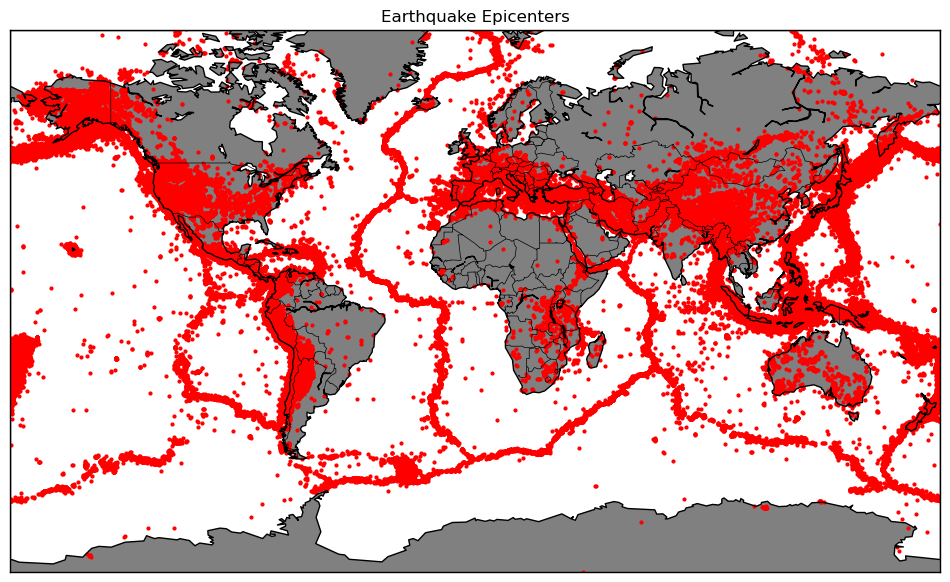

In [7]:
# This cell extracts longitude and latitude data from a DataFrame, converts them to map coordinates,
# and plots them on a map with markers. The markers are represented in red and signify earthquake epicenters.

from mpl_toolkits.basemap import Basemap

input_file_path = "C:\\Users\\user\\cleaned_earthquake_data.csv"
df = pd.read_csv(input_file_path)

m = Basemap(projection='mill', llcrnrlat=-80, urcrnrlat=80, llcrnrlon=-180, urcrnrlon=180, lat_ts=20, resolution='c')

longitudes = df["Longitude"].tolist()
latitudes = df["Latitude"].tolist()

x,y = m(longitudes,latitudes)

fig = plt.figure(figsize=(12,10))
plt.title("Earthquake Epicenters")
m.plot(x, y, "o", markersize = 2, color = 'red')
m.drawcoastlines()
m.fillcontinents(color='grey',lake_color='white')
m.drawmapboundary()
m.drawcountries()
plt.show()

In [8]:
# This cell is intended for feature engineering of the cleaned earthquake data. 

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import BallTree
from tqdm import tqdm

input_file_path = "C:\\Users\\user\\cleaned_earthquake_data.csv"
df = pd.read_csv(input_file_path)

def get_magnitude_class(magnitude):
    if magnitude >= 8.0:
        return "Great"
    elif 7.0 <= magnitude < 8.0:
        return "Major"
    elif 6.0 <= magnitude < 7.0:
        return "Strong"
    elif 5.0 <= magnitude < 6.0:
        return "Moderate"
    elif 4.0 <= magnitude < 5.0:
        return "Light"
    elif 3.0 <= magnitude < 4.0:
        return "Minor"
    else:
        return "Micro"

df['Magnitude Class'] = df['Magnitude'].apply(get_magnitude_class)

df['Lat Rad'] = np.radians(df['Latitude'])
df['Long Rad'] = np.radians(df['Longitude'])

radius = 0.0157 # 100km
coordinates = df[['Lat Rad', 'Long Rad']].values
ball_tree = BallTree(coordinates, metric='haversine')

density_feature = []
for coord in tqdm(coordinates, desc="Processing", unit="data point"):
    neighbors = ball_tree.query_radius(coord.reshape(1, -1), r=radius, count_only=True)
    density_feature.append(neighbors[0])

df['Density'] = density_feature

scaler = StandardScaler()
df['Density'] = scaler.fit_transform(df['Density'].values.reshape(-1, 1))

time_interval = '1ME'
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Frequency'] = df.groupby(pd.Grouper(key='Timestamp', freq=time_interval))['Timestamp'].transform('count')

output_file_path = "C:\\Users\\user\\feature_engineered_earthquake_data.csv"
df.to_csv(output_file_path, index=False)

num_columns = df.shape[1]
num_rows = df.shape[0]
data_types = df.dtypes
dataset_size = df.memory_usage().sum() / (1024 * 1024)

print("Number of columns:", num_columns)
print("Number of rows:", num_rows)
print("Data Types of each column:")
print(data_types)
print("Dataset size:", round(dataset_size, 2), "MB")
print("Feature engineered dataset saved to:", output_file_path)

Processing: 100%|████████████████████████████████████████████████████| 621125/621125 [02:06<00:00, 4907.22data point/s]


Number of columns: 12
Number of rows: 621125
Data Types of each column:
Timestamp           datetime64[ns]
Latitude                   float64
Longitude                  float64
Depth                      float64
Magnitude                  float64
Magnitude Type              object
Root Mean Square           float64
Magnitude Class             object
Lat Rad                    float64
Long Rad                   float64
Density                    float64
Frequency                    int64
dtype: object
Dataset size: 56.87 MB
Feature engineered dataset saved to: C:\Users\user\feature_engineered_earthquake_data.csv


In [9]:
# This cell entails the modeling of architecture and training.

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

dataset_path = "C:\\Users\\user\\feature_engineered_earthquake_data.csv"
data = pd.read_csv(dataset_path)

data = data.drop(columns=['Timestamp', 'Magnitude Type', 'Latitude', 'Longitude', 'Root Mean Square'])
X = data[['Magnitude', 'Depth', 'Lat Rad', 'Long Rad', 'Density', 'Frequency']]
y = data['Magnitude Class']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

def create_model(dropout_rate=0.0, learning_rate=0.001):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(6,)),
        Dropout(dropout_rate),
        Dense(256, activation='relu'),
        Dropout(dropout_rate),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dropout(dropout_rate),
        Dense(7, activation='softmax')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
history = model.fit(X_train_scaled, y_train, batch_size=64, epochs=20)

accuracy = model.evaluate(X_val_scaled, y_val)[1]
print(f'Accuracy on validation set: {accuracy * 100:.2f}%')

Epoch 1/20
7765/7765 [==============================] - 13s 2ms/step - loss: 0.0522 - accuracy: 0.9808
Epoch 2/20
7765/7765 [==============================] - 12s 2ms/step - loss: 0.0225 - accuracy: 0.9921
Epoch 3/20
7765/7765 [==============================] - 14s 2ms/step - loss: 0.0160 - accuracy: 0.9944
Epoch 4/20
7765/7765 [==============================] - 12s 2ms/step - loss: 0.0133 - accuracy: 0.9952
Epoch 5/20
7765/7765 [==============================] - 13s 2ms/step - loss: 0.0120 - accuracy: 0.9959
Epoch 6/20
7765/7765 [==============================] - 12s 2ms/step - loss: 0.0105 - accuracy: 0.9963
Epoch 7/20
7765/7765 [==============================] - 13s 2ms/step - loss: 0.0094 - accuracy: 0.9967
Epoch 8/20
7765/7765 [==============================] - 13s 2ms/step - loss: 0.0086 - accuracy: 0.9969
Epoch 9/20
7765/7765 [==============================] - 13s 2ms/step - loss: 0.0083 - accuracy: 0.9972
Epoch 10/20
7765/7765 [==============================] - 14s 2ms/step - l

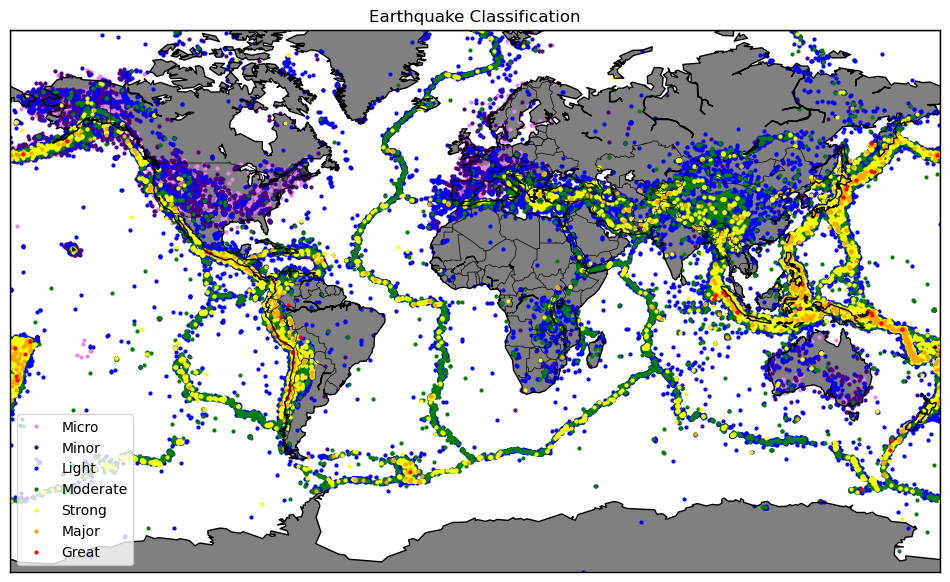

In [10]:
# This cell extracts longitude and latitude data from a DataFrame, converts them to map coordinates,
# and plots them on a map with markers. The markers are represented in different colors, corresponding a magnitude class.

from mpl_toolkits.basemap import Basemap

m = Basemap(projection='mill', llcrnrlat=-80, urcrnrlat=80, llcrnrlon=-180, urcrnrlon=180, lat_ts=20, resolution='c')

micro_df = df[df['Magnitude Class'] == 'Micro']
minor_df = df[df['Magnitude Class'] == 'Minor']
light_df = df[df['Magnitude Class'] == 'Light']
moderate_df = df[df['Magnitude Class'] == 'Moderate']
strong_df = df[df['Magnitude Class'] == 'Strong']
major_df = df[df['Magnitude Class'] == 'Major']
great_df = df[df['Magnitude Class'] == 'Great']

micro_x, micro_y = m(micro_df["Longitude"].tolist(), micro_df["Latitude"].tolist())
minor_x, minor_y = m(minor_df["Longitude"].tolist(), minor_df["Latitude"].tolist())
light_x, light_y = m(light_df["Longitude"].tolist(), light_df["Latitude"].tolist())
moderate_x, moderate_y = m(moderate_df["Longitude"].tolist(), moderate_df["Latitude"].tolist())
strong_x, strong_y = m(strong_df["Longitude"].tolist(), strong_df["Latitude"].tolist())
major_x, major_y = m(major_df["Longitude"].tolist(), major_df["Latitude"].tolist())
great_x, great_y = m(great_df["Longitude"].tolist(), great_df["Latitude"].tolist())

fig = plt.figure(figsize=(12, 10))

plt.title("Earthquake Classification")

m.plot(micro_x, micro_y, "o", markersize=2, color='violet', label='Micro')
m.plot(minor_x, minor_y, "o", markersize=2, color='indigo', label='Minor')
m.plot(light_x, light_y, "o", markersize=2, color='blue', label='Light')
m.plot(moderate_x, moderate_y, "o", markersize=2, color='green', label='Moderate')
m.plot(strong_x, strong_y, "o", markersize=2, color='yellow', label='Strong')
m.plot(major_x, major_y, "o", markersize=2, color='orange', label='Major')
m.plot(great_x, great_y, "o", markersize=2, color='red', label='Great')

m.drawcoastlines()
m.fillcontinents(color='grey', lake_color='white')
m.drawmapboundary()
m.drawcountries()
plt.legend()
plt.show()

3883/3883 [==============================] - 4s 1ms/step


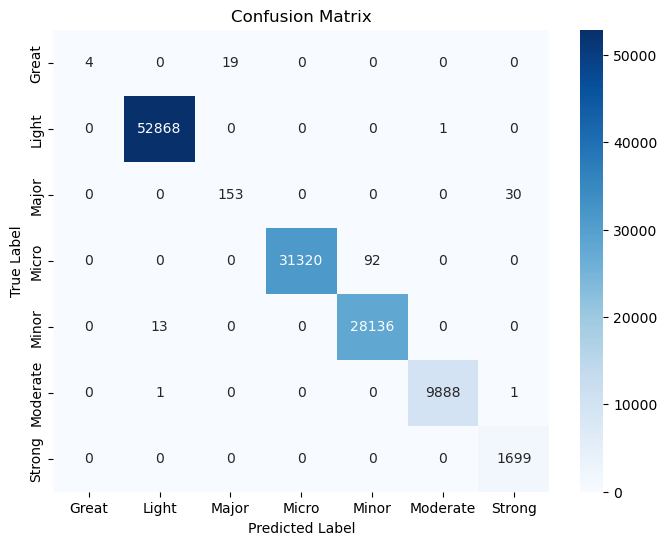

In [11]:
# This cell entails the model validation and Confusion Matrix.

from sklearn.metrics import confusion_matrix

y_pred = np.argmax(model.predict(X_val_scaled), axis=1)

labels = label_encoder.classes_
conf_matrix = confusion_matrix(np.argmax(y_val, axis=1), y_pred, labels=range(len(labels)))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()